In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.transform import resize, rescale
import pyclustering.cluster.kmedians
import random
from skimage import data, exposure, img_as_float
from scipy import arange
from collections import defaultdict
from operator import itemgetter
import scipy
from matplotlib.colors import ListedColormap
from sklearn import metrics

In [3]:
def show_image(image):
    plt.imshow(image)
    plt.show()

In [64]:
# load photo
photo = io.imread('data/zdj_3.png')
photo = photo[:,:,:3] # dro alpha channel
print (photo.shape[0], photo.shape[1])

photo = resize(photo, (150, 150))
X_range = photo.shape[0]
Y_range = photo.shape[1]

782 1043


/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


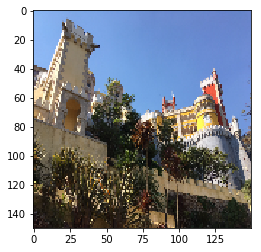

In [65]:
show_image(photo)

In [66]:
def calculate_histogram_of_colors():
    step = 0.1
    histogram_result = {}
    for pixel in photo.reshape((X_range*Y_range, 3)):
        for red in arange(0.0, 1.0, step):
            for green in arange (0.0, 1.0, step):
                for blue in arange (0.0, 1.0, step):
                    if pixel[0] >= red and pixel[0] < (red + step) and pixel[1] >= green and pixel[1] < (green + step) and pixel[2] >= blue and pixel[2] < (blue + step):
                            key = (red, green, blue)
                            if key in histogram_result:
                                histogram_result[key].append(pixel)
                            else:
                                histogram_result[key] = [pixel]
                            break
    return histogram_result

In [67]:
def create_count_of_elements_from_histogram_result(histogram_result):
    histogram_count = defaultdict(int)
    for key, value in histogram_result.items():
        for elem in value:
            histogram_count[key] += 1
    return histogram_count

In [70]:
number_of_colors_to_pick = 20

In [71]:
histogram_result = calculate_histogram_of_colors()

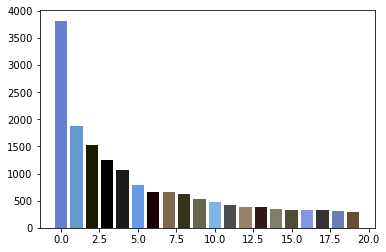

In [72]:
hist_count = create_count_of_elements_from_histogram_result(histogram_result)
sorted_hist_count = sorted(hist_count.items(), key=itemgetter(1), reverse=True)
most_popular_colors = sorted_hist_count[:number_of_colors_to_pick]
#print (most_popular_colors)
colors = []
values = []
for tup in most_popular_colors:
    colors.append(tup[0])
    values.append(tup[1])

plt.bar(np.arange(number_of_colors_to_pick), height=values, color=colors)
plt.show()

In [81]:
number_of_clusters = 5

In [90]:
random_x = np.random.random_integers(1, X_range, number_of_clusters)
random_y = np.random.random_integers(1, Y_range, number_of_clusters)
random_centers_coordinates = list(zip(random_x, random_y))
random_centers = []
for pair in random_centers_coordinates:
    x_ = pair[0]
    y_ = pair[1]
    random_centers.append(photo[x_, y_])
random_centers_np = np.array(random_centers)
print (photo.shape)
print (random_centers_np.shape)
pixels_flattened = photo.reshape((X_range*Y_range, 3))
kmedians_instance = pyclustering.cluster.kmedians.kmedians(data=pixels_flattened, 
                                                           initial_centers=random_centers_np,
                                                           ccore = False)
kmedians_instance.process()
clusters = kmedians_instance.get_clusters()

(150, 150, 3)
(5, 3)


/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 150 + 1) instead
  """Entry point for launching an IPython kernel.
/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(1, 150 + 1) instead
  


In [91]:
def retrieve_values_from_clusters(clusters):
    pixels_clustered = []
    for cluster_idx, cluster in enumerate(clusters):
        pixels_clustered.append([])
        for idx in cluster:
            pixels_clustered[cluster_idx].append(pixels_flattened[idx])
    return np.array(pixels_clustered)

In [92]:
pca = PCA(n_components=2)

In [93]:
def plot_cluster(X, colors):
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

In [94]:
clustered = retrieve_values_from_clusters(clusters)
#clustered
print (clustered.shape)

X = []
Y = []
clustered_points = {}
for idx, cluster in enumerate(clustered):
    for item in cluster:
        X.append(item)
        Y.append(idx)

after_pca = pca.fit_transform(X, Y)


(5,)


In [95]:
def predict(medians, points):
    print (len(points))
    results = []
    for point in points:
        min_value = 10000000
        min_idx = -1
        for idx, median in enumerate(medians):
            euclid = scipy.spatial.distance.euclidean(point, median)
            if euclid < min_value:
                min_value = euclid
                min_idx = idx
        results.append(min_idx)
    return results

26445
[[0.38380130718954147, 0.34509803921568627, 0.29234509803923586], [0.48235294117647065, 0.65489028322440068, 0.88272339869281002], [0.58629176470588273, 0.51005873638344257, 0.41173856209150994], [0.41691041394335376, 0.55191363834422724, 0.82641673202614363], [0.14418692810457315, 0.12596095860566892, 0.085964705882349557]]


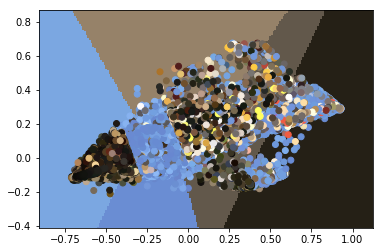

In [96]:
x_min, x_max = after_pca[:, 0].min() - 0.2, after_pca[:, 0].max() + 0.2
y_min, y_max = after_pca[:, 1].min() - 0.2, after_pca[: , 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
medians_pca = pca.fit_transform(kmedians_instance.get_medians())
Z = predict(medians_pca, np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z)

Z = Z.reshape(xx.shape)

cluster_colors = kmedians_instance.get_medians()
print (cluster_colors)

    
colors_to_plot = ListedColormap(cluster_colors)

color_sequence = []
for x in photo:
    for y in x:
        color_sequence.append(y)
plt.pcolormesh(xx, yy, Z, cmap=colors_to_plot)
    #plt.pcolorsmesh(Z, interpolation='nearest',  extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#           color=colors_hex)
plt.scatter(after_pca[:, 0], after_pca[:, 1], c=color_sequence)
plt.show()

In [89]:
print ("number of clusters: " + str(number_of_clusters) + ", score: " + str(metrics.silhouette_score(X, Y)))

number of clusters: 5, score: 0.334370113066
